*Autores: Alex H. Pfoccori Quispe, Milton A. Mozo Davila*

# Modelamiento No Lineal

En este laboratorio, volvemos a analizar los datos salariales considerados en los ejemplos de este capítulo, para ilustrar el ehcho de qu emuchos de los procedimientos complejos de ajuste no lineal discutido pueden implementarse fácilmente en ***R***. Comenzamos cargando la biblioteca ***ISLR***, que contiene los datos.

In [1]:
library(ISLR)
attach(Wage)

## Regresión Polinámica y Funciones Escalonadas

A continuación examinamos cómo se ha elaborado la figura qu ese muestra a continuación.

In [2]:
fit=lm(wage~poly(age, 4), data=Wage)
coef(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287409,153.283015,0.000000e+00
"poly(age, 4)1",447.06785,39.9147851,11.200558,1.484604e-28
"poly(age, 4)2",-478.31581,39.9147851,-11.983424,2.355831e-32
"poly(age, 4)3",125.52169,39.9147851,3.144742,1.678622e-03
"poly(age, 4)4",-77.91118,39.9147851,-1.951938,5.103865e-02


Esta sintaxis ajusta un modelo lineal, utilizando la función ***lm()***, para predecir el salario ***wage*** utilizando un polinomio de cuarto grado en la ***age:poly(age, 4)***. El comando ***poly()*** nos permite evitar tener que escribir una larga fórmula con potencias de la edad ***age***. La función devuelve una matriz cuyas columnas son una base de polinomis ortogonales, loq ue significa esecialmente que cada columna es una combinación lineal de las variables age, age2, age3, age4.

Sin embargo, también podmeos utilizar ***poly()*** para obtener *age, age2, age3 y age4* directamente, si lo preferimos. Podemos hacerlo utilizando el argumento ***raw=TRUE*** en la función ***poly()***. Más adelante veremos que esto no afecta calaramente a las estimaciones de los coeficientes, no afecta a los valores ajustados obtenidos.

In [3]:
fit2=lm(wage~poly(age, 4, raw=T), data=Wage)
coef(summary(fit2))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.841542e+02,6.004038e+01,-3.067172,0.0021802539
"poly(age, 4, raw = T)1",2.124552e+01,5.886748e+00,3.609042,0.0003123618
"poly(age, 4, raw = T)2",-5.638593e-01,2.061083e-01,-2.735743,0.0062606446
"poly(age, 4, raw = T)3",6.810688e-03,3.065931e-03,2.221409,0.0263977518
"poly(age, 4, raw = T)4",-3.203830e-05,1.641359e-05,-1.951938,0.0510386498


Hay otras formas equivalentes de ajustar este modelo, que muestran la flexibilidad del lenguaje de fórmulas en ***R***. Por ejemplo:

In [4]:
fit2a=lm(wage~age+I(age^2)+I(age^3)+I(age^4), data=Wage)
coef(fit2a)

(Intercept)           age      I(age^2)      I(age^3)      I(age^4) 
-1.841542e+02  2.124552e+01 -5.638593e-01  6.810688e-03 -3.203830e-05

Esto simplemente crea las funciones base polinómicas sobre la marcha, teniendo cuidado de proteger términos como age^2 a traves de la función envolvente ***I()***

In [5]:
fit2b=lm(wage~cbind(age, age^2, age^3, age^4), data=Wage)

Esto hace lo mismo de forma más compacta, utilizando la función ***cbind()*** para construir una matriz a partir de una colección de vectores; cualquier llamada a una función como ***cbind()*** dentro de una fórmula también sirve de envoltorio.

Ahora creamos una cuadrícula de valores para la edad ***age*** ala que queremos hacer predicciones, y llamamos a la función genérica ***predict()***, especificando que también queremos errores estándar.

In [6]:
agelims=range(age)
age.grid=seq(from=agelims[1], to=agelims[2])
preds=predict(fit, newdata=list(age=age.grid), se=TRUE)
se.bands=cbind(preds$fit + 2*preds$se.fit, preds$fit - 2*preds$se.fit)

Por último, trazamos lso datos y añadimos el ajuste de polinomio de grado 4.

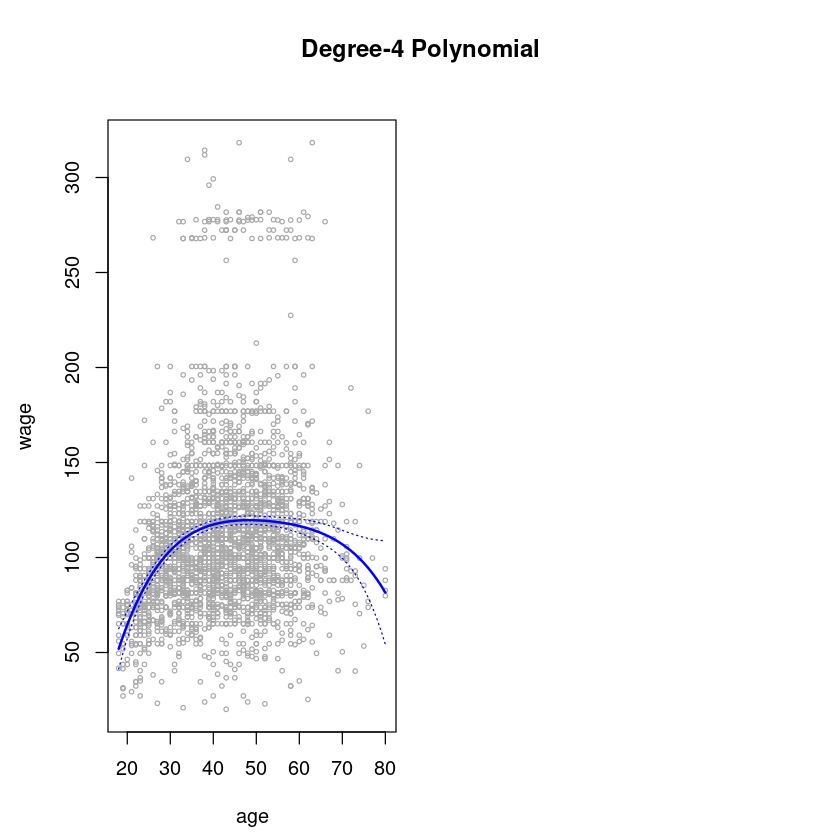

In [7]:
par(mfrow=c(1,2), mar=c(4.5, 4.5, 1, 1), oma=c(0, 0, 4, 0))
plot(age, wage, xlim=agelims, cex=.5, col="darkgrey")
title("Degree-4 Polynomial", outer=T)
lines(age.grid, preds$fit, lwd=2, col="blue")
matlines(age.grid, se.bands, lwd=1, col="blue", lty=3)

Aquí los argumentos ***mar*** y ***oma*** de ***par()*** nos permite controlar los márgenes del gráfico y la función ***title()*** crea un título de figura que abarca ambos subplots. Hemos mencionado antes que el hecho de que se prduzca o no un conjutno ortogonal de funcones base en la función ***poly()*** no afectará al modelo obtenido de manera signinficativa. ¿Qué queremos decir con esto?

Los valores ajustados obtenidos en ambos casos son idénticos:

In [8]:
preds2=predict(fit2, newdata=list(age=age.grid), se=TRUE)
max(abs(preds$fit - preds2$fit))

[1] 7.197798e-11

Al realizar una regresión polinómica debemos decidir el grado del polinómio a utilizar. Una forma de hacerlo es utilizando pruebas de hipótesis. Ahora ajustamos modelos que van desde el lineal hasta el polinómio de grado 5 y buscamos determinar el modelo más sencillo que sea suficiente para explicar la relación entre el salario ***wage*** y la edad ***age***. Utilizamos la función **anova()***, que realiza un análisis de la varianza para probar la hipótesis nula de que un modelo *M1* es suficiente para explicar lod datos contra la hipótesis alternativa de que se requiere un modelo más complejo *M2*. Para utilizar la función ***anova()***, *M1* y *M2* deben ser modelos anidados: los predictores de *M1* deben ser un subconjutno de los predictores de *M2*. En este caso ajustamos cinco modelos diferentes y comparamos secuencialmente el modelo más sencillo con el modelo más complejo.

In [9]:
fit.1=lm(wage~age, data=Wage)
fit.2=lm(wage~poly(age,2), data=Wage)
fit.3=lm(wage~poly(age,3), data=Wage)
fit.4=lm(wage~poly(age,4), data=Wage)
fit.5=lm(wage~poly(age,5), data=Wage)
anova(fit.1, fit.2, fit.3, fit.4, fit.5)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2998,5022216,NA,NA,NA,NA
2,2997,4793430,1,228786.010,143.5931074,2.367734e-32
3,2996,4777674,1,15755.694,9.8887559,1.679213e-03
4,2995,4771604,1,6070.152,3.8098134,5.104623e-02
5,2994,4770322,1,1282.563,0.8049758,3.696820e-01


El valor de p que compara el modelo lineal 1 con el modelo cuadrático 2 es esencialmente cero (<10-15), lo que indica que un ajuste lineal no es suficiente. Del mismo modo, el valo rde p que compara el modelo cuadrático 2 con el modelo cúbico 3 es muy bajo (0.0017), por lo que el ajuste cuadrático también es insuficiente. El valor p comparado los polinomios cúbicos y de gadro 4, el modelo 3 y el modelo 4, es de aproximadamente el 55, mientras que el polinomio de grado 5 del modelo 5 parece innecesario porque su valor p es de 0.37. Por lo tanto, un polinómio cúbico o un cuártico parecen proporcionar un ajuste razonable a los datos, pero ambos modelos de orden inferior o superior de orden superior no están justificados.
En este caso, en lugar de utiliar la función ***anova()***, podríamos haber obtenido estos valores p de forma más sucinta explotando el hecho de que ***poly()*** crea polinómios ortogonales.

In [10]:
coef(summary(fit.5))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287647,153.2780243,0.000000e+00
"poly(age, 5)1",447.06785,39.9160847,11.2001930,1.491111e-28
"poly(age, 5)2",-478.31581,39.9160847,-11.9830341,2.367734e-32
"poly(age, 5)3",125.52169,39.9160847,3.1446392,1.679213e-03
"poly(age, 5)4",-77.91118,39.9160847,-1.9518743,5.104623e-02
"poly(age, 5)5",-35.81289,39.9160847,-0.8972045,3.696820e-01


Obsérvese que los valores de p son los mismos y, de hecho, el cuadrado de las t son iguales a lso estadísticos F de la función ***anova()***; por ejemplo:

In [11]:
(-11.983)^2

[1] 143.5923

Sin embargo, el método ANOVA funciona tanto si utilizamos polinomios ortogonales como también no ortogonales; también funciona cuando tenemos otros términos en el modelo. Por ejemplo, podemos utilizar ***anova()*** para comparar estos tres modelos.

In [12]:
fit.1=lm(wage~education+age, data=Wage)
fit.2=lm(wage~education+poly(age,2), data=Wage)
fit.3=lm(wage~education+poly(age,3), data=Wage)
anova(fit.1,fit.2,fit.3)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2994,3867992,NA,NA,NA,NA
2,2993,3725395,1,142597.10,114.696898,2.728971e-26
3,2992,3719809,1,5586.66,4.493588,3.410431e-02


Como alternativa a la utilizaciónde ppruebas de hipótesis y ANOVA, podríamos elegir el graod polinómico utilizando la validación cruzada. A continuación, consideramos la tarea d epredecir si un individuo grana más de 250 000 dólares al año. Procedemos como antes, excepto que primero creamos el vecto r de respuesta apropiado, y luego aplicamos la función ***glm()*** usando ***family="binomial"*** para ajustar un modelo de regresión logística polinomial.

In [13]:
fit=glm(I(wage>250)~poly(age,4), data=Wage, family=binomial)

Obsérvese que volvemos a utlizar el wrapper ***I()*** para crear esta varaible de respuesta binaria sobre la marcha. La expresión ***wage>250*** se evalúa como una variable lógica que contiene ***TRUE***s y ***FALSE***s, ***glm()*** convierte en binaria estableciendo los TRUEs a 1 y FALSEs a 0

Una vez más, hacemos predicciones utilzando la función ***predict()***.

In [14]:
preds=predict(fit, newdata=list(age=age.grid), se=T)

Sin embargo, el cálculo de lso intervalos de confianza es algo más complicado que en el caso de la regresión  lineal. El tipo de predicción por defecto para un modelo ***glm()*** es ***type="link"***, que es el que utilizamos aquí. Esto significa que obtenemos predicciones apra el logaritmo, es decir, hacemos ajustes de la forma.

Y las predicciones dadas son de la forma XB. Los errores estándar dados son también de esta forma. Para obtener intervalos de confianza para *Pr(Y=1|X)*, utilizamos la transformación.

In [15]:
pfit=exp(preds$fit)/(1+exp(preds$fit))
se.bands.logit=cbind(preds$fit + 2*preds$se.fit, preds$fit - 2*preds$se.fit)
se.bands=exp(se.bands.logit)/(1+exp(se.bands.logit))

Sin embargo, los intervalos de confianza correspondientes no habrían sido sensatos porque acabaríamos con probabilidades negativas. Por último, el gráfico de la derecha de la figura se hizo de la siguiente manera.

In [16]:
preds=predict(fit, newdata=list(age=age.grid), type="response", se=T)

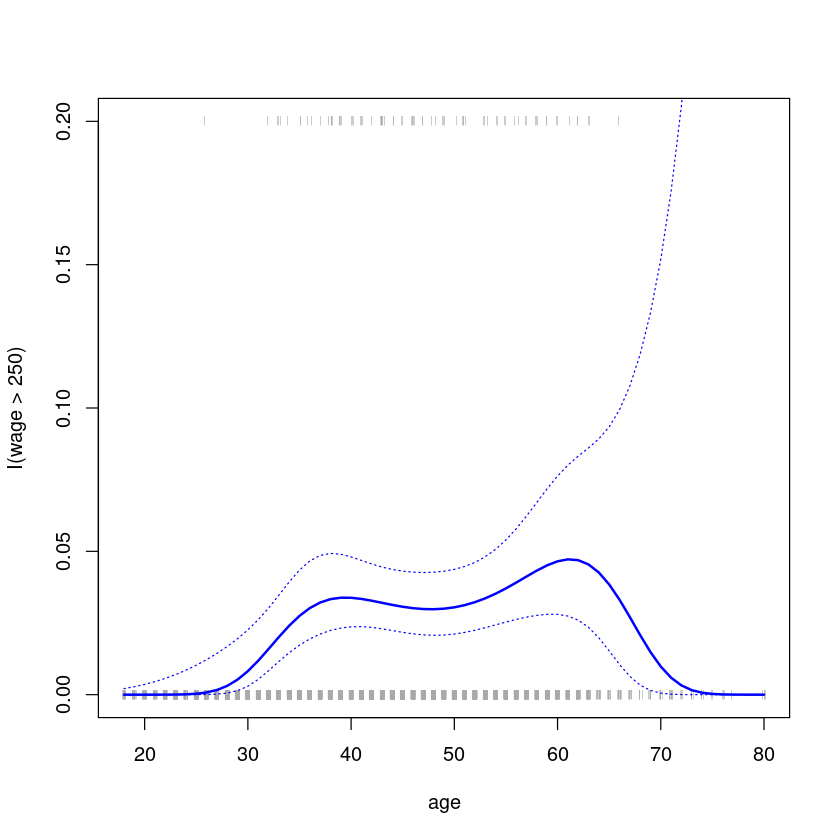

In [17]:
plot(age, I(wage>250), xlim=agelims, type="n", ylim=c(0, .2))
points(jitter(age), I((wage>250)/5), cex=.5, pch="|", col="darkgrey")
lines(age.grid, pfit, lwd=2, col="blue")
matlines(age.grid, se.bands, lwd=1, col="blue", lty=3)

Hemos dibujado los valore de ***age*** correspondientes a las observaciones con valores salariales superiores a 250 como marcas grises en la parte superior del gráfico, y los que tienen valores salariales inferiores como marcas grises en la parte inferior. Hemos utilizado la función ***jitter()*** para desplazar un poco los valore de edad(), de modo que las observaciones con el mismo valor de edad ***age*** no se tapen unas a otas. Esto se llama a menudo un gráfico de alfombra. Para ajustar una función escalonada, utilizamos la función ***cut()***.

In [18]:
table(cut(age, 4))


(17.9,33.5]   (33.5,49]   (49,64.5] (64.5,80.1] 
        750        1399         779          72 

In [19]:
fit=lm(wage~cut(age,4), data=Wage)
coef(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),94.158392,1.476069,63.789970,0.000000e+00
"cut(age, 4)(33.5,49]",24.053491,1.829431,13.148074,1.982315e-38
"cut(age, 4)(49,64.5]",23.664559,2.067958,11.443444,1.040750e-29
"cut(age, 4)(64.5,80.1]",7.640592,4.987424,1.531972,1.256350e-01


Aquí ***cut()*** eligió automáticamente los puntos de corte a lso 33.5, 49 y 64.5 años de edad. También podríamos haber especificado nuestro propios puntos de corte directamente utlizando la opción ***breaks***. La función ***cut()*** devuelve una variable categórica ordenada; la función ***lm()*** crea entonces un conjunto de variables ficticias para utilizarlas en la regresión.

## Splines

Para ajustar splines de regresión en R, utilizamos la biblioteca splines. En el libro, respecto a la sección 7.4 vimos que los splines de regresión pueden ajustarse contruyendo una matriz de funciones base. La función ***bs()*** genera la matriz completa de funciones base apra splines con el conjunto de nodos especificado. Por defecto, se producen spines cúbicos. Ajustar el salario a a edad utilizando spline de regresión es sencillo.

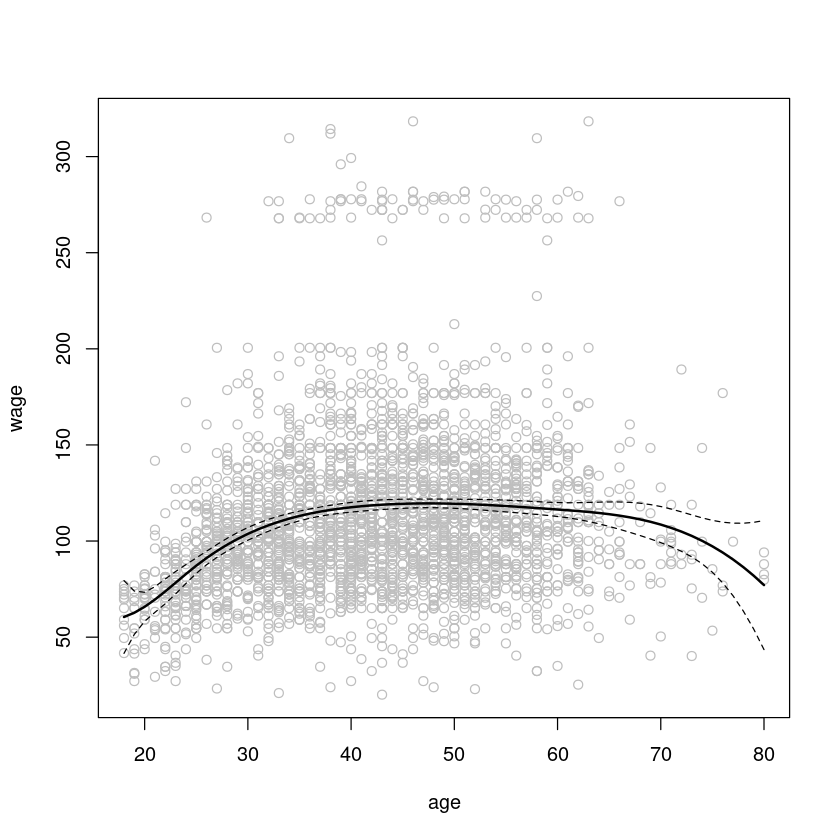

In [20]:
library(splines)
fit=lm(wage~bs(age, knots=c(25, 40, 60)), data=Wage)
pred=predict(fit, newdata=list(age=age.grid), se=T)
plot(age, wage, col="gray")
lines(age.grid, pred$fit, lwd=2)
lines(age.grid, pred$fit + 2*pred$se, lty="dashed")
lines(age.grid, pred$fit - 2*pred$se, lty="dashed")

Aquí tenemos nudos preestablecidos a las edasde de 25, 40 y 60 años. Esto produce un spline con seis funciones de base. (Recordemos que un spline cúbico con tres nodos tiene siete grados de libertad; estos grados de libertad son utilizados por un intercepción, más seis funciones base). También podemos utilizar la opción ***df*** para producir un spline con nudos en cuantiles uniformes de los datos.

In [21]:
dim(bs(age, knots=c(25, 40, 60)))

[1] 3000    6

In [22]:
dim(bs(age, df=6))

[1] 3000    6

In [23]:
attr(bs(age, df=6),"knots")

25%   50%   75% 
33.75 42.00 51.00

En este caso, ***R*** elige los nodos en las edades 33.75, 42, y 51, que corresponden a los percentiles 25, 50 y 75 de edad. La función ***bs*** también tiene un argumento de grado, por lo que podemos ajustar splines de cualquier grado, en lugar de grado por defecto de 3. Para ajustar un spline natural, utilizamos la función ***ns()***. Aquí ajustamos un spline natural con cuatro grados de libertad.

Warning message in smooth.spline(age, wage, cv = TRUE):
“cross-validation with non-unique 'x' values seems doubtful”


[1] 6.794596

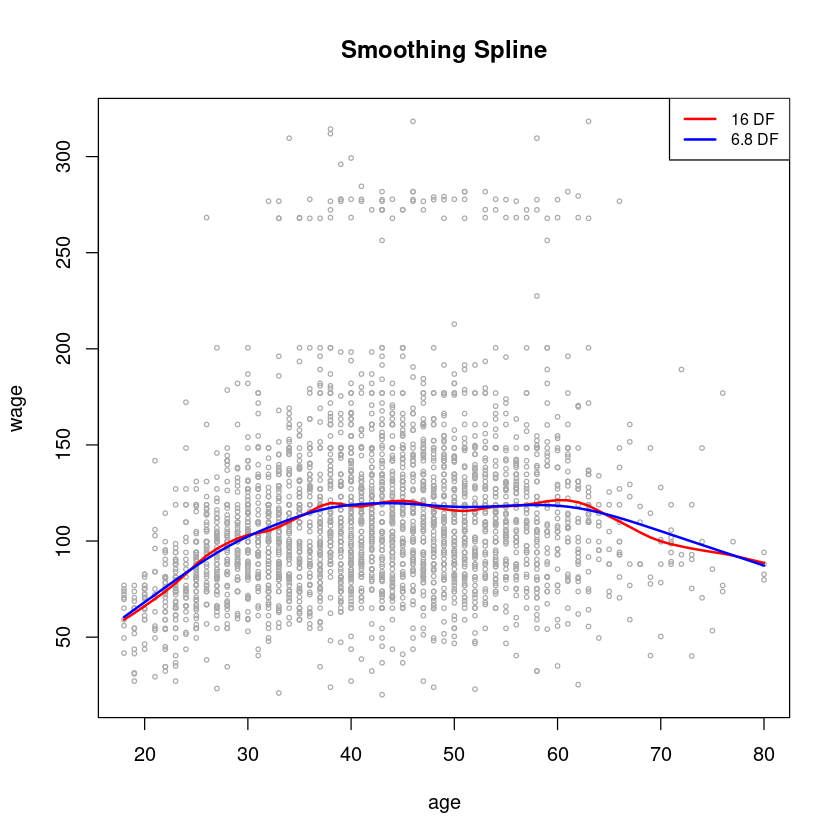

In [24]:
plot(age,wage,xlim=agelims, cex=.5, col="darkgrey")
title("Smoothing Spline")
fit=smooth.spline(age, wage, df=16)
fit2=smooth.spline(age, wage, cv=TRUE)
fit2$df
lines(fit,col="red", lwd=2)
lines(fit2,col="blue", lwd=2)
legend("topright", legend=c("16 DF", "6.8 DF"), col=c("red", "blue"), lty=1, lwd=2, cex=.8)

Observe que en la primera llamada a ***smooth.spline()***, especificamos ***df=16***. La función determina que valor de lambda conduce a 16 grados de libertad. En la segunda llamada a ***smooth.spline()***, seleccionamos el nivel de suavidad por validación cruzada; esto resulta en un valor de lambda que produce 6.8 grados de libertad.

La realizar la regresión lineal, utilizamos la función ***loess()***

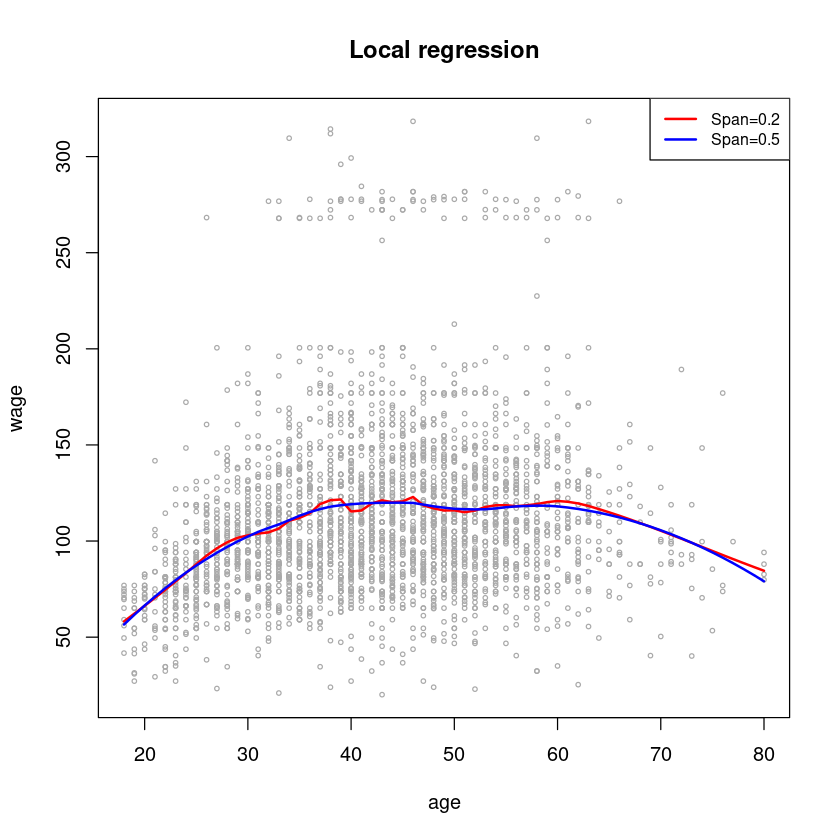

In [25]:
plot(age,wage,xlim=agelims, cex=.5, col="darkgrey")
title("Local regression")
fit=loess(wage~age, span=.2, data=Wage)
fit2=loess(wage~age, span=.5, data=Wage)
lines(age.grid, predict(fit, data.frame(age=age.grid)), col="red", lwd=2)
lines(age.grid, predict(fit2, data.frame(age=age.grid)), col="blue", lwd=2)
legend("topright", legend=c("Span=0.2", "Span=0.5"), col=c("red", "blue"), lty=1, lwd=2, cex=.8)

Aquí hemos realizado una regresión lineal local utilizando espaciados de 0.2 y 0.5 es decir, cada vecindario está formado pro el 20% o el 50% de las observaciones. Cuanto mayor sea el intervalo, más suave será el ajuste. La biblioteca ***locfit*** también puede utilizarse para ajustar modleos de regresión local en ***R***.

# GAMs

Ahora ajustamos un GAM para predecir el salario ***wage*** utilizando funciones spline naturales del año ***year*** y la edad ***age***, tratando la educación como un predictor cualitativo. Como se trata simplemente de un gran modelo de regresión lineal que utiliza una elección adecuada de funciones base, podemos hacerlo simplemente utilizando la función ***lm()***.

In [26]:
gam1=lm(wage~ns(year, 4) + ns(age, 5) + education, data=Wage)

Ahora ajustamos el modelo anterior utilizando splines de suavizado en lugar de splines naturales. para ajustar tipos más generales de GAM, utilizamos splines de suavizado u otros componentes que no pueden expresarse en términos de funciones de base y luego ajustarse utilizando la regresión por mínimos cuadrados, tendremos que utilizar la biblioteca ***gam*** en ***R***. La función ***s()***, que forma parte de la biblioteca ***gam***, se utiliza para indicar que queremos utilizar un spline de suavización. Especificamos que la función de año ***year*** debe tener 4 grados de libertad, y que la función de la edad tendrá 5 grados de libertad, y que la función de edad tendrá 5 grados de libertad. Como la educación es cualitativa, la función ***gam()*** para ajustar un GAM utilizando estos componentes, teniendo en cuenta cada uno de ellos para explicar la resuesta.

Loading required package: foreach

Loaded gam 1.20.2




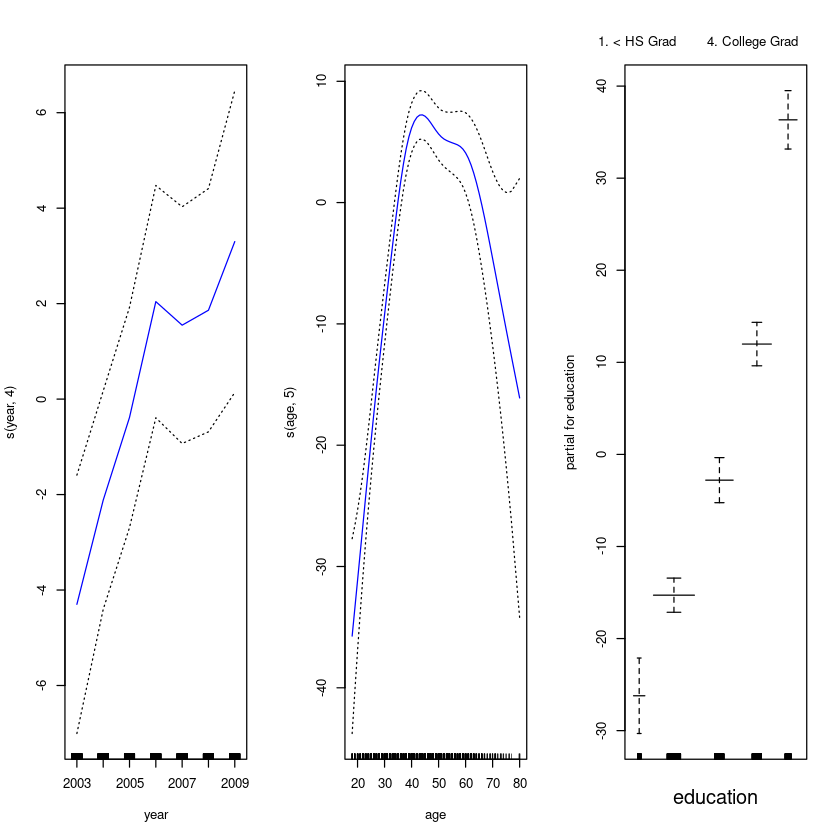

In [27]:
library(gam)
gam.m3=gam(wage~s(year, 4)+s(age, 5)+education, data=Wage)
par(mfrow=c(1,3))
plot(gam.m3, se=TRUE, col="blue")

La función genérica ***plot()*** reconce que ***gam2*** es un objeto de la clase ***gam***, e invoca el método ***plot.gam()*** apropiado. Convenientemente, aunque ***gam1*** no es de la clase ***gam*** sino de la clase ***lm***, podemos seguir utilizando ***plot.gam()*** en ella. La figura que se muestra a continuación se produjo utilizando la siguiente expresión.

In [28]:
plot.gam(gam1, se=TRUE, col="red")

ERROR: Error in plot.gam(gam1, se = TRUE, col = "red"): no se pudo encontrar la función "plot.gam"


Observe que aquí tuvimos que usar ***plot.gam()*** en lugar de la función genérica ***plot()*** genérico. En esots gráficos, la función del año parace bastante lineal. Podemos realizar una serie de pruebas ANOVA para determinar cuúal de estos tres modelos es mejor: un GAM que excluye el año, un GAM que utilice una función lineal del año, o un GAM que utiliza una función spline del año.

In [29]:
gam.m1=gam(wage~s(age, 5)+education, data=Wage)
gam.m2=gam(wage~year+s(age, 5) + education, data=Wage)
anova(gam.m1, gam.m2, gam.m3, test="F")

,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2990,3711731,NA,NA,NA,NA
2,2989,3693842,1.000000,17889.243,14.477130,0.0001447167
3,2986,3689770,2.999989,4071.134,1.098212,0.3485661430


Econtramos que hay pruebas convincentes de que un GAM con una función lineal del año es mejor que un GAM que no incluye el año en absoluto (valor p=0.00014). Sin embargo, no hay pruebas de que sea necesaria una función no lineal del año (valor p=0.349). En otras palabras, según los resultados de este ANOVA, se prefiere a *M2*.

In [30]:
summary(gam.m3)


Call: gam(formula = wage ~ s(year, 4) + s(age, 5) + education, data = Wage)
Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-119.43  -19.70   -3.33   14.17  213.48 

(Dispersion Parameter for gaussian family taken to be 1235.69)

    Null Deviance: 5222086 on 2999 degrees of freedom
Residual Deviance: 3689770 on 2986 degrees of freedom
AIC: 29887.75 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
             Df  Sum Sq Mean Sq F value    Pr(>F)    
s(year, 4)    1   27162   27162  21.981 2.877e-06 ***
s(age, 5)     1  195338  195338 158.081 < 2.2e-16 ***
education     4 1069726  267432 216.423 < 2.2e-16 ***
Residuals  2986 3689770    1236                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
            Npar Df Npar F  Pr(F)    
(Intercept)                          
s(year, 4)        3  1.086 0.3537    
s(age, 5)         4 32.380 <2e-16 ***
education                            
--

Los valores de p para el año y la edad corresponden a una hipótesis nula de una relación lineal frente a la aternativa de una relación no lineal. El gran valor para p para el año refuerza nuestra conclusión de la prueba ANOVA de una función lineal es adecuada para este término.
Sin embargo, hay pruebas muy claras de que se requiere un término no lineal para la edad. Podemos hacer predicciones a partir de los objetos ***gam***, al igual que de los objetos ***lm***, utilizando el método ***predict*** para la clase ***gam***.

In [31]:
pred=predict(gam.m2, newdata=Wage)

In [32]:
gam.lo=gam(wage~s(year, df=4) + lo(age, span=0.7) + education, data=Wage)
plot.gam(gam.lo, se=TRUE, col="green")

ERROR: Error in plot.gam(gam.lo, se = TRUE, col = "green"): no se pudo encontrar la función "plot.gam"


In [33]:
gam.lo.i=gam(wage~lo(year, age, span=0.5) + education, data=Wage)

Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“liv too small.    (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“lv too small.     (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“liv too small.    (Discovered by lowesd)”
Warning message in lo.wam(x, z, wz, fit$smooth, which, fit$smooth.frame, bf.maxit, :
“lv too small.     (Discovered by lowesd)”


                    
education            FALSE TRUE
  1. < HS Grad         268    0
  2. HS Grad           966    5
  3. Some College      643    7
  4. College Grad      663   22
  5. Advanced Degree   381   45

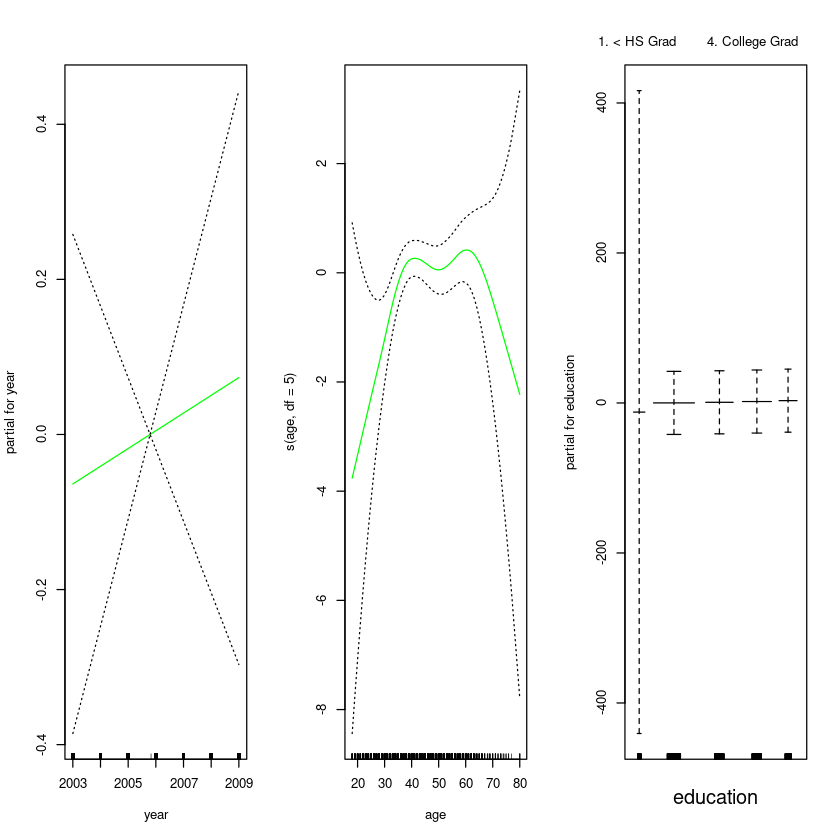

In [34]:
gam.lr=gam(I(wage>250)~year+s(age, df=5)+education, family=binomial, data=Wage)
par(mfrow=c(1,3))
plot(gam.lr, se=T, col="green")
table(education, I(wage>250))

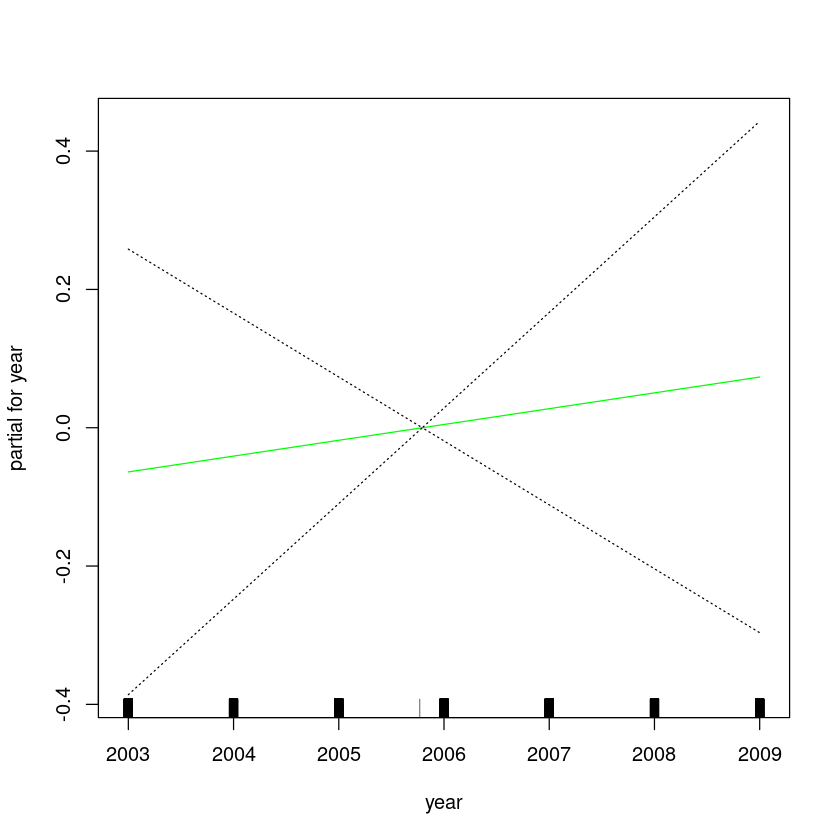

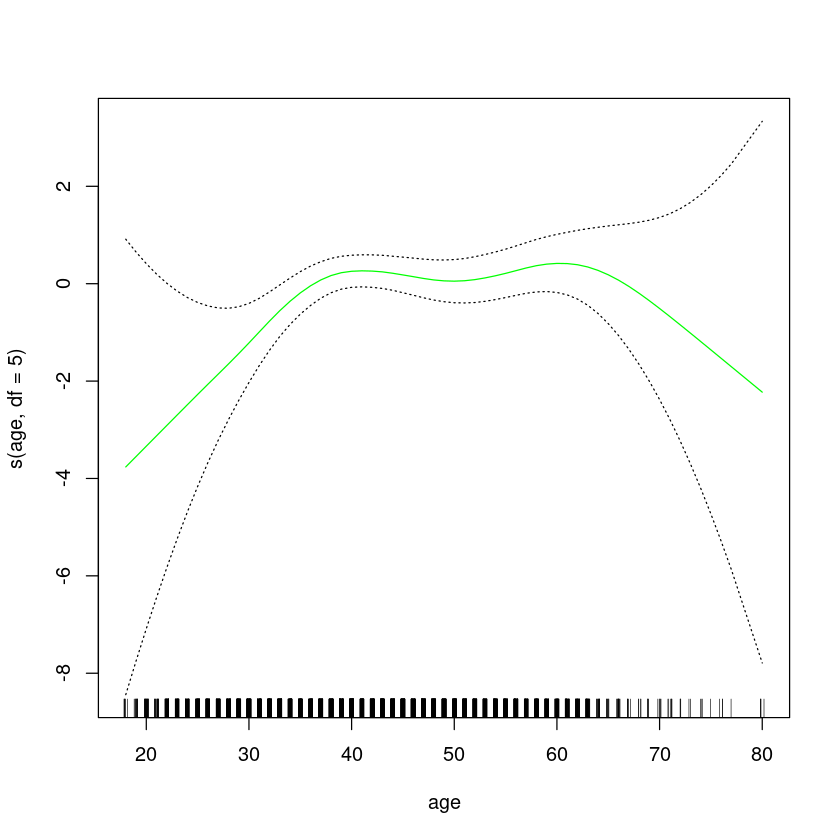

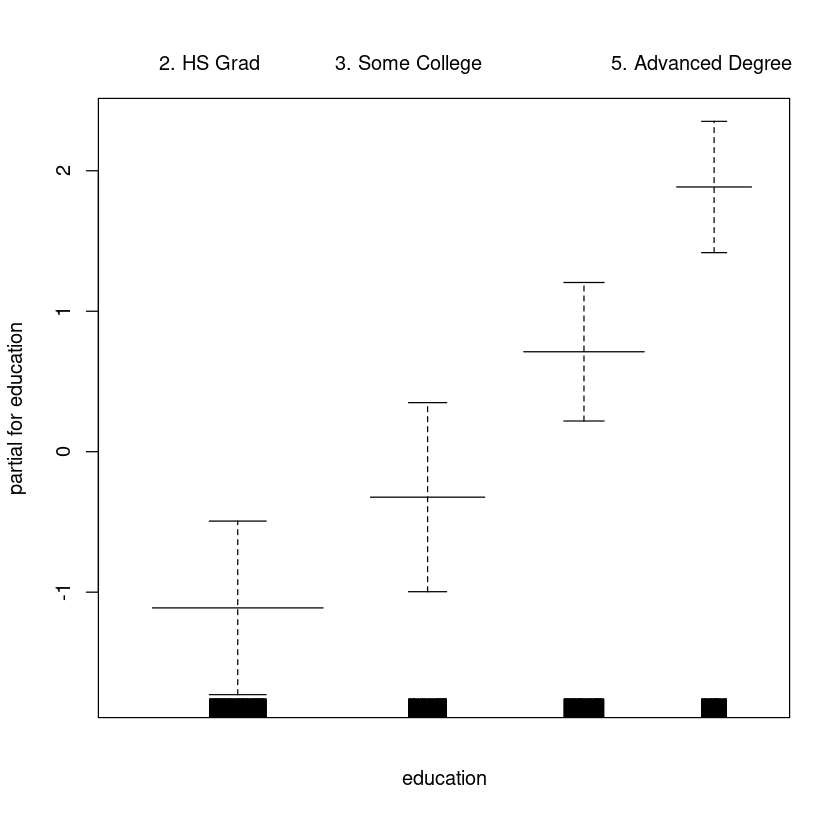

In [35]:
gam.lr.s=gam(I(wage>250)~year+s(age, df=5)+education, family=binomial, data=Wage, subset=(education!="1. < HS Grad"))
plot(gam.lr.s, se=T, col="green")